# Modelado Jerárquico {#sec-hierarchical-models}

In [1]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit as logistic

In [2]:
#| code-fold: true

az.style.use('arviz-doc')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Los objetivos de este capítulo son:

 * Aprender sobre modelos jerárquicos
    * agrupamiento-parcial
    * efecto de _contracción_

## Jerarquías en los datos

Al analizar datos es común encontrarse con situaciones como las siguientes:

 * Datos de desempeño deportivo. Por ejemplo datos de los mismos corredores en diferentes años.
 * Datos de salud. Por ejemplo datos de pacientes en diferentes hospitales.
 * Datos de rendimiento escolar. Podríamos tener información sobre el rendimiento de los estudiantes en diferentes escuelas, de diferentes ciudades y en diferentes provincias.

En todos estos casos lo que tenemos es una agrupamiento o jerarquía "natural". Los datos están agrupados en diferentes niveles. En el caso de los estudiantes, los datos están agrupados por escuela, ciudad y provincia. En el caso de los pacientes, los datos están agrupados por hospital. En el caso de los corredores tenemos mediciones repetidas de un mismo individuo a lo largo del tiempo, es decir los datos están agrupados por corredor.

Es muy común que al analizar estos datos ignoremos la estructura jerárquica de los datos y decidamos o bien agrupar los datos (ej, todos los corredores en un mismo grupo) o bien analizarlos por separado (cada corredor, independiente del resto). Agrupar todos los datos nos permite obtener estimaciones más precisas, el costo es que perdemos los detalles de cada grupo. Al agrupar datos también corremos el riesgo de opacar diferencias o incluso obtener conclusiones diametralmente opuestas (ver [paradoja de Simpson](https://en.wikipedia.org/wiki/Simpson%27s_paradox)). Tratar a cada grupo por separado tiene la ventaja que podemos capturar las particularidades de cada grupo, pero las estimaciones de los parámetros serán menos precisas y corremos el riesgo de sobre-ajuste. 

¿Es posible construir un modelo que contemple que los datos están formados por grupos diferentes, pero que al mismo tiempo comparten información? 

Si, y ese es precisamente el tema principal de este capítulo. Este tipo de modelos se conocen como modelos jerárquicos. En la literatura es posible encontrar el mismo concepto bajo diferentes nombres; modelos multinivel, modelos de efectos mixtos, modelos de efectos aleatorios o modelos anidados. Lamentablemente algunos autores utilizan estos términos de forma intercambiable, mientras que otros los utilizan para marcar algunas diferencias. Nosotros utilizaremos el término modelo jerárquico para referirnos a cualquier modelo que contemple la estructura jerárquica de los datos.

Un modelo jerárquico se construye asignado distribuciones a priori a las distribuciones a priori! Este nivel superior de distribuciones a priori se suelen denominar hiper-priors. Conceptualmente al utilizar un hiper-prior, estamos asumiendo que los priors de cada grupo no son nesariamente idénticos, pero si están vinculados al provenir de una población (o mecanismo generarador de datos) común. La siguiente figura muestra un diagrama con las diferencias entre un modelo agrupado (un solo grupo), un modelo no agrupado (todos los grupos separados) y un modelo jerárquico.

![Diagrama que muestra las diferencias entre un modelo agrupado, un modelo no agrupado y un modelo jerárquico.](img/hierarchical_model.png)

El introducir hiper-priors induce una distribución a posteriori donde las estimaciones de cada grupo estarán parcialmente agrupadas, es decir en algún punto entre el modelo agrupado y el modelo no agrupado. Para generar intuición sobre este punto construyamos un modelo no-jerarquico y uno jerárquico y compararemos los resultados.

## Desplazamientos jerárquicos

Las [proteínas](https://www.youtube.com/watch?v=wvTv8TqWC48) son moléculas formadas por 20 unidades, llamadas amino ácidos, cada amino ácido puede aparecer en una proteína 0 o más veces. Así como una melodía está definida por una sucesión de notas musicales, una proteína está definida por una sucesión de amino ácidos. Algunas variaciones de notas pueden dar como resultados pequeñas variaciones sobre la misma melodía, otras variaciones pueden resultar en melodías completamente distintas, algo similar sucede con las proteínas. Una forma de estudiar proteínas es usando resonancia magnética nuclear (la misma técnica usada para imágenes médicas). Esta técnica permite medir diversos _observables_, uno de ellos se llama _desplazamiento químico_ y para simplificar diremos que podemos medir tantos desplazamientos químicos como amino ácidos tenga una proteína. Los aminoácidos son una familia de compuestos químicos por lo que tendría sentido tratarlos a todos de igual forma, pero al mismo tiempo tienen diferentes propiedades químicas, las cuales de hecho son relevantes para comprender como funcionan las proteínas! Por lo que también tiene sentido tratarlos por separado. Como ya vimos una alternativa es construir un modelo jerárquico y hacer algo a mitad de camino.

El siguiente conjunto de datos contiene valores de desplazamientos químicos para un conjunto de proteínas. Si inspeccionan el DataFrame `cs_data` verán que tiene 4 columnas:

* La primera es un código que identifica a la proteína (si tienen curiosidad pueden ingresar el identificador en esta base de datos <https://www.rcsb.org>).
* La segunda columna tiene el nombre del amino ácido (pueden corroborar que hay tan solo 20 nombres únicos).
* La tercera contiene valores teóricos de desplazamientos químicos (calculados usando métodos cuánticos).
* La cuarta tiene valores experimentales.

La motivación de este ejemplo es comparar las diferencias entre valores teóricos y experimentales, entre otras razones para evaluar la capacidad de los métodos teóricos para reproducir valores experimentales.


In [4]:
cs_data = pd.read_csv('datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

Para resaltar la diferencia entre un modelo jerárquico y uno no-jerárquico vamos a construir ambos. Primero el no-jerárquico. Este modelo es equivalente a haber ajustado cada uno de los `aa` grupos por separado.

In [5]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Y ahora la novedad. El modelo jerárquico.

Este modelo tiene un hiper-prior para la media de $\mu$ (`μ_mu`) y otro para la desviación estándar de $\mu$ (`μ_sd`). Para $\sigma$ no usamos un hiper-prior, asumimos un valor común del parámetro para todos los grupos. Esto es una decisión de modelado. En este caso la justificación es mantener el ejemplo simple, pero en principio no sería problemático usar un hiper-prior también para $\sigma$.

In [6]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=2)
    μ_sd = pm.HalfNormal('μ_sd', 2)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━  28% 0:00:19 / 0:00:07

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Antes de observar los resultados, comparemos gráficamente ambos modelos, para estar seguros que entendemos en qué difieren. La siguiente figura muestra una representación gráfica de los modelos `cs_nh` (no-jerárquico) y `cs_h` (jerárquico). Se puede ver como el modelo jerárquico tiene un nivel más.


<div>
<img src="img/cs_nh_vs_h.png" width="700"/>
</div>


Ahora que tenemos más claras las diferencias a nivel del modelo, vamos a explorar las consecuencias de esas diferencias. Para ello vamos a comparar los resultados usando un forest plot. ArviZ nos ofrece la función `plot_forest` que permite pasar más de un modelo, esto es útil cuando queremos comparar los valores de parámetros equivalentes entre modelos como en el presente ejemplo. Por defecto, `plot_forest` grafica las cadenas de MCMC por separado, esto no es relevante en este caso por lo que vamos a combinarlas usando `combined=True`. Los invito a explorar, por su cuenta, el significado del resto de los argumentos que pasamos en la siguiente celda.

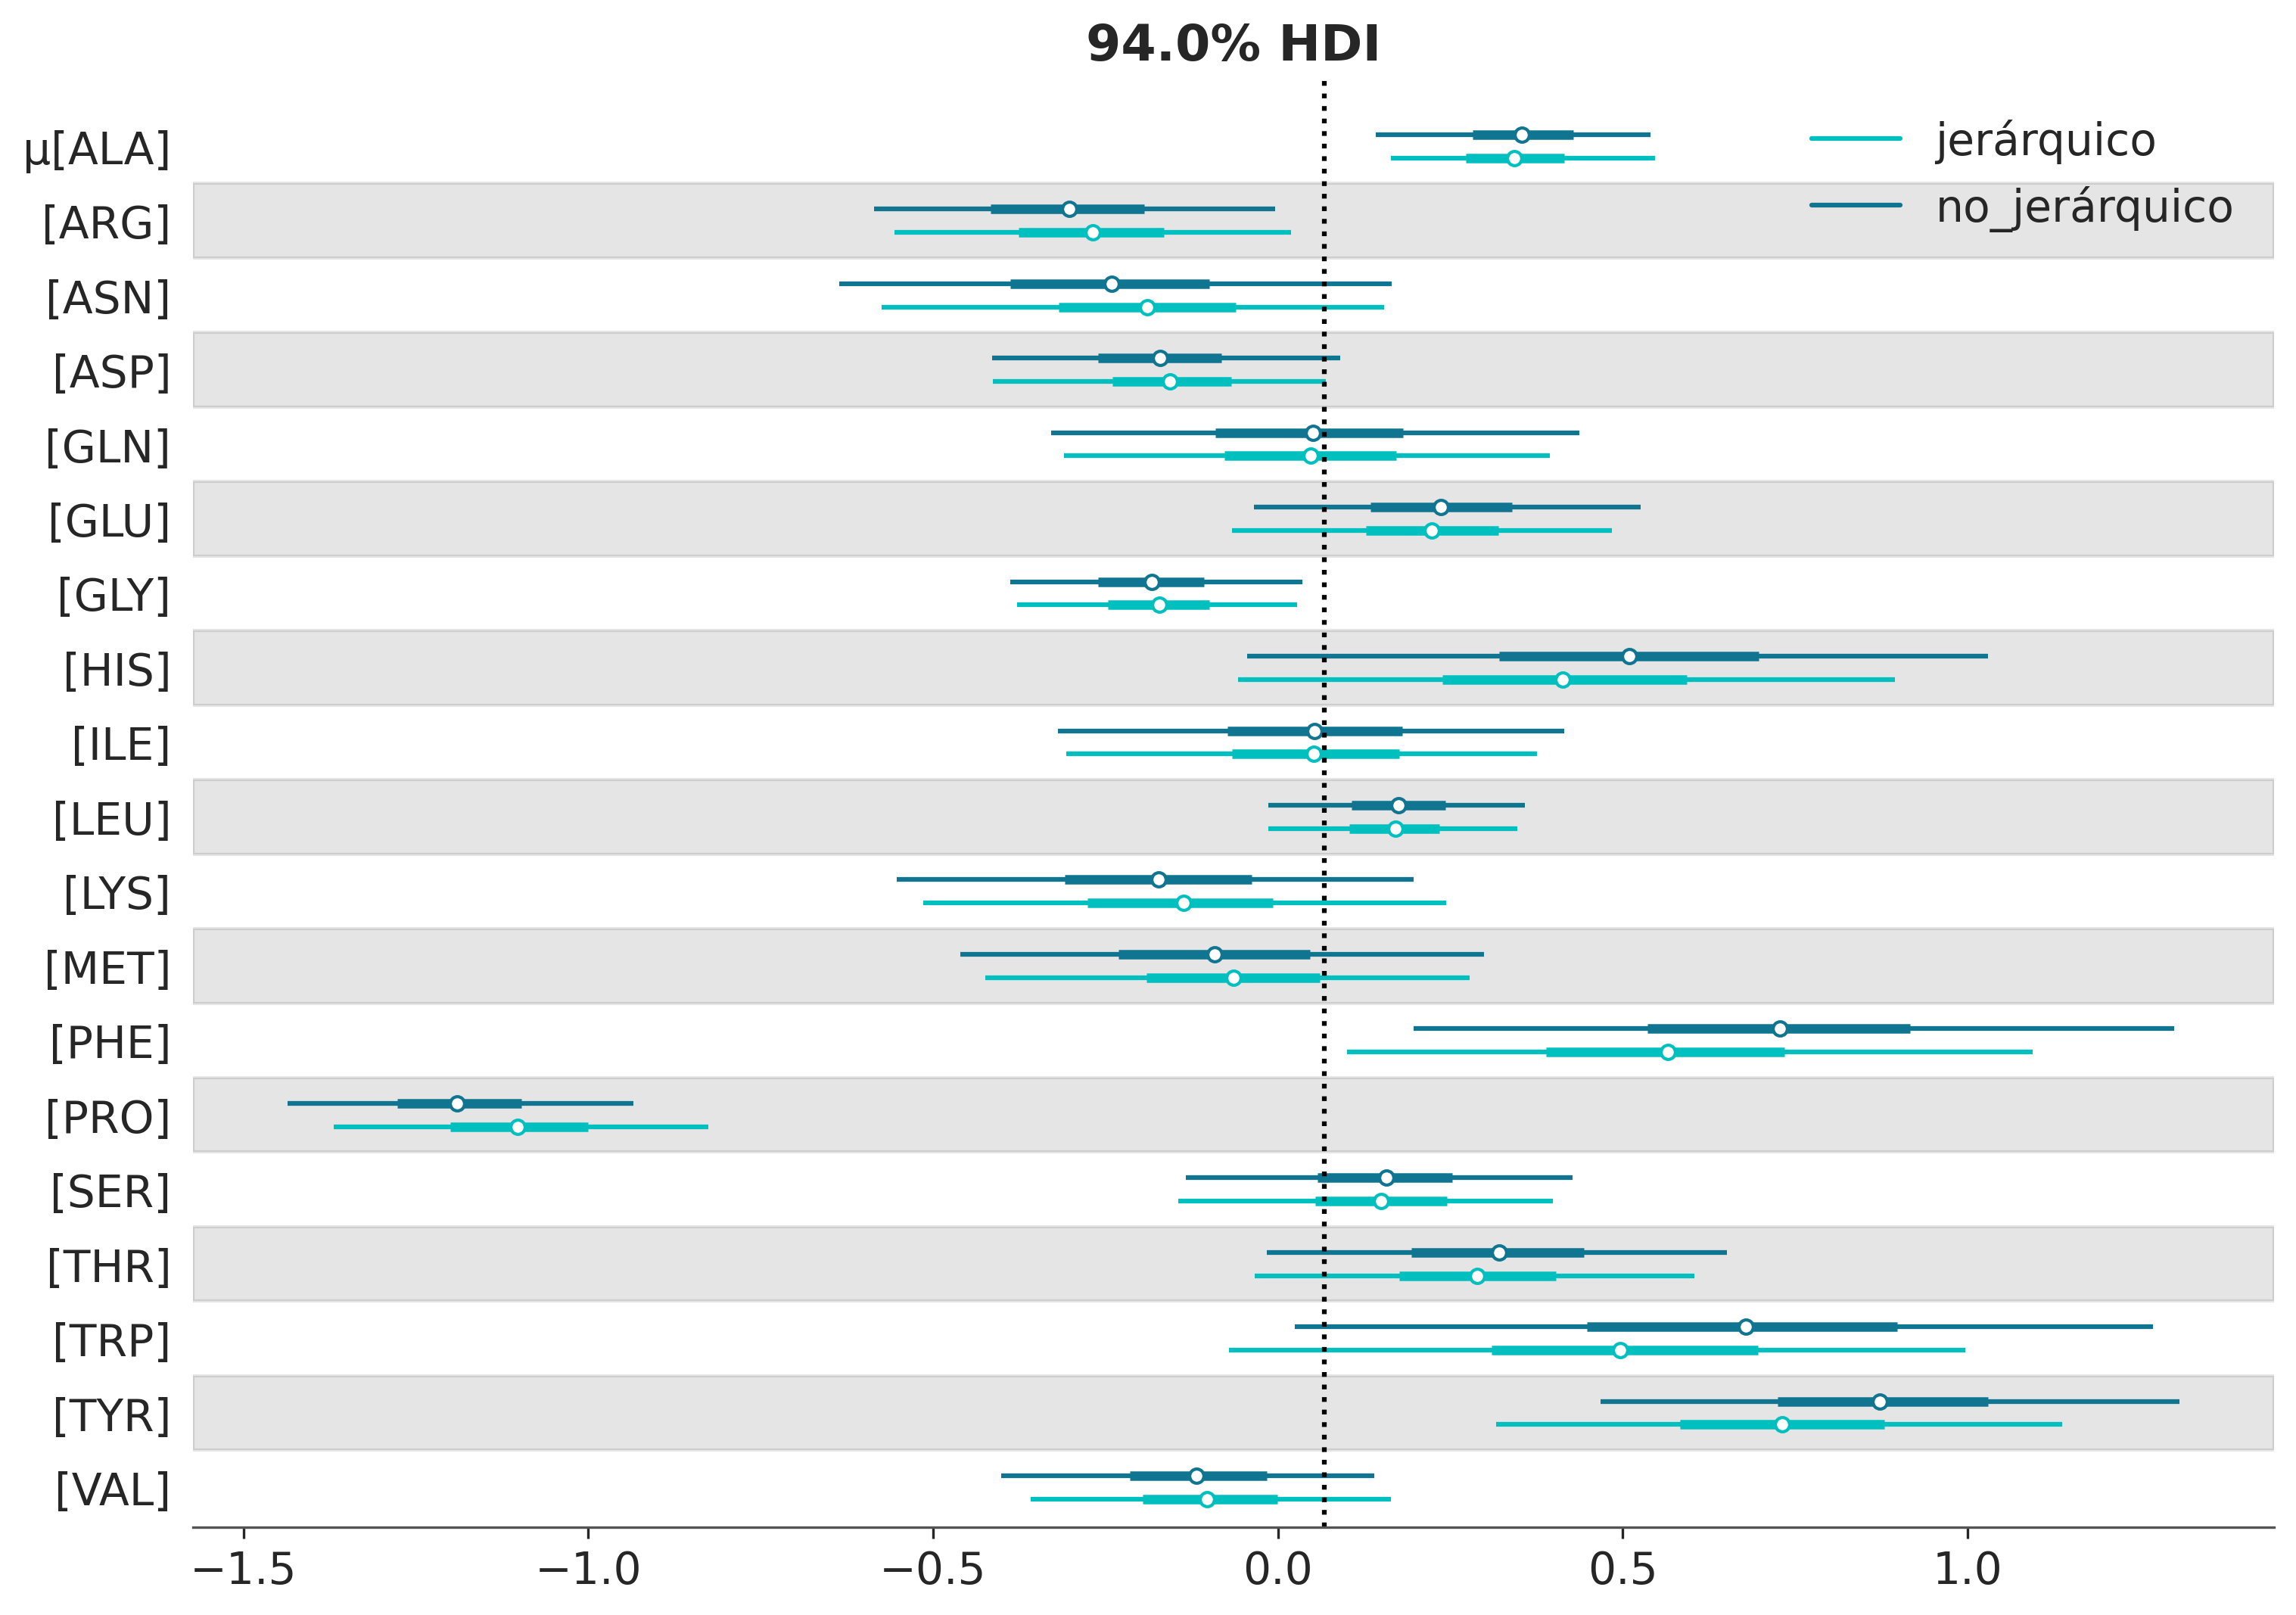

In [7]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['no_jerárquico', 'jerárquico'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 7),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

Bien, tenemos un gráfico para 38 valores medios estimados, uno por aminoácido (19 en este conjunto de datos) y esto duplicado ya que tenemos dos modelos. También tenemos los intervalos de credibilidad del 94% y el rango intercuartil (el intervalo que contiene el 50% central de la distribución). La línea vertical es la media parcialmente agrupada, es decir la media según el modelo jerárquico. El valor es cercano a cero, esto es parte de lo que esperaríamos ver si los valores teóricos son buenos reproduciendo los valores experimentales. 

La parte más relevante de este gráfico es que las estimaciones del modelo jerárquico son _atraídas_ hacia la media parcialmente agrupada o, de forma equivalente, se _contraen_ con respecto a las estimaciones no agrupadas. Este efecto es más notorio para los grupos más alejados de la media (como PRO), además la incertidumbre es igual o menor que la del modelo no jerárquico. Decimos que las estimaciones están parcialmente agrupadas porque tenemos una estimación para cada grupo, pero las estimaciones para cada grupo se informan mutuamente mediante el hiper prior. Por lo tanto, se obtiene una situación intermedia entre tener un solo grupo (la media global), todos los aminoácidos juntos, y tener 20 grupos separados, uno por aminoácido (el modelo no jerárquico). 



::: {.callout-note}
En un modelo jerárquico, los grupos que comparten un hiperprior común comparten información a través de ese hiperprior. 
Esto da como resultado una contracción de las estimaciones, respecto del modelo desagrupado. Es decir, las estimaciones individuales se contraen hacia la media común. 
Al agrupar parcialemente las estimaciones, estamos modelando los grupos en algún punto medio entre grupos independientes unos de otros y un solo gran grupo.
:::

## Es deseable tener contracción?

Un modelo jerárquico ofrece estimaciones más conservadoras y más robustas. Por ejemplo, si un grupo tiene un tamaño de muestra pequeño, la estimación de ese grupo será más incierta que la de un grupo con un tamaño de muestra grande. En un modelo jerárquico, la información de los grupos con mayor tamaño de muestra se comparte con los grupos con menor tamaño de muestra, lo que resulta en una estimación más precisa para los grupos con menor tamaño de muestra. La cantidad exacta de contracción dependerá de varios factores (ver ejercicios), pero en general, la contracción es deseable ya que reduce la varianza de las estimaciones y reduce las posibilidades de sobreajuste.

## Intercambiabilidad

Una secuencia, finita o infinita de variables aleatorias $X_1, X_2, X_3, \dots X_j$ es intercambiable si su distribución de probabilidad conjunta no se ve modificada por permutaciones de los indices $(1, \dots, J)$. 


Un ejemplo típico de variables intercambiables es el siguiente:

Tenemos una bolsa con una bola blanca y una negra. La probabilidad de sacar cualquiera de ellas es de 0.5. Si $Y_i = 1$ indica que la iésima bola es blanca y muestreando sin reemplazo, tendremos que:


$$P(X_1=1, X_2=0) = 0.5$$
$$P(X_1=0, X_2=1) = 0.5$$

Es decir la probabilidad de tomar primero la blanca y luego la negra es igual a tomar primero la blanca y luego la negra. Es decir $X_1$ e $X_2$ son intercambiables.

Ahora bien también es cierto que:

$$0 = P(X_2=1 \mid X_1=1) \not= P(X_2=1) = 0.5$$

Es decir la probabilidad marginal de que la segunda bola sea blanca no es la misma que la probabilidad (condicional) de que la segunda sea blanca dado que ya obtuvimos una blanca. Es decir $X_1$ e $X_2$ no son independientes.

> Toda secuencia iid es también intercambiable, pero una secuencia intercambiable no es necesariamente iid. La condición de intercambialidad es más general (o menos *estricta*) que la de independencia.

Este enunciado se puede demostrar de la siguiente forma:


Sea $x_i \mathop{\sim}\limits^{iid} p(x)$, tenemos que la probabilidad conjunta se calcula como el producto de las probabilidades marginales:


$$p(x_i, \dots , x_n) = \prod_i^n p(x_i)$$


Dado que el producto es commutativo, tenemos que el resultado es invariante a permutaciones.

OK, todo muy lindo, pero y que tiene que ver esto con modelos jerárquicos? Por ahora parece que nada, pero avancemos un poco más.

## Teorema de De Finetti

Una secuencia de variables aleatorias es intercambiable si y solo si para todo $n$ podemos escribir:


$$p(X_1, X_2,  \dots , X_n) = \int \prod_i^n p(X_i \mid \theta) \; p(\theta)$$

Es decir, que conjunto de variable aleatorias puede ser descrito por:

* un parámetro $\theta$
* un likelihood $p(X \mid \theta)$
* un prior $p(\theta)$

Entonces podemos ver al teorema de De Finetti como una justificación de la estadística Bayesiana y como una garantía de que si tenemos una secuencia de observaciones/variables aleatorias intercambiables entoces podremos describirlas adecuadamente usando estadística Bayesiana. La trampa, por que siempre hay una trampa, es que el teorema no nos dice nada sobre como elegir ni el parámetro, ni el likelihood ni el prior. Existen algunas justificaciones teóricas para elegir estos elementos, pero no lo discutiremos en este curso, principalmente por su limitada utilidad práctica.

Supongamos ahora que $\theta$ representa un conjunto de parámetros, $\theta = (\theta_1, \theta_2,  \dots , \theta_n)$ y que este conjunto de parámetros es intercambiable. Entonces podemos escribir:

$$(\theta_1, \theta_2,  \dots , \theta_n) = \int \prod_i^n p(\theta_i \mid \psi) \; p(\psi)$$


Obteniendo un modelo jerárquico que podríamos reescribir como:


\begin{align*}
X_{ij} &\sim p(X \mid \theta_i) \\
\theta_i &\sim p(\theta \mid \psi)  \\
\psi &\sim p(\psi) 
\end{align*}


## Intercambiabilidad e inferencia

Yo he seleccionado 10 valores de desplazamientos químicos $y_1, \dots, y_{10}$. Qué me pueden decir del valor $y_4$? Sin conocer algo de la química de aminoácidos es dificil arriesgar un rango razonable para $y_4$, pero si asumen intercambialidad podrían decir $y_4$ debe parecerse a los demás valores, ya que no hay razón para pensar que $y_4$ sea especial, por ejemplo para decir algo como $y_4 > y_3$ necesitarían información adicional o supuestos adicionales, como asumir un orden dado. Es decir intercambialidad, implica cierto grado de ignorancia.

Bien, ahora supongamos que les muestro 9 valores, excepto $y_4$, qué pueden decir de $y_4$?

| $y_1$   | $y_2$   | $y_3$   | $y_5$   | $y_6$   | $y_7$   | $y_8$   | $y_9$   | $y_{10}$   |
|---------|---------|---------|---------|---------|---------|---------|---------|------------|
| 58.27   | 56.18   | 56.84   | 54.64   | 54.2    | 57.51   | 44.45   | 61.46   | 54.45      |


Podrían decir que es posible que $y_4$ esté comprendido en ese rango y si están dispuestos a asumir normalidad, entonces pueden decir algo más como que es probable que $y_4$ tenga una valor de 54.9 (la media de los otros valores) y sería extraño que tenga una valor inferior a $\approx 41$ y superior a $\approx 68$ ($54.9 \pm 3 \text{ desvíos estándar}$). Esta estimación es válida incluso si reordenamos los valores de la tabla anterior. Estamos asumiendo que $y_4$ es intercambiable, pero no independiente, ya que de alguna forma el valor de $y_4$ está "informado" por los otros valores.

Alguien podría objetar que este análisis no es válido, ya que existen distintos tipos de aminoácidos y en algunos casos los desplazamientos pueden ser muy diferentes para estos distintos tipos. En ese caso podemos responder de al menos 2 formas. 

* Si solo tenemos los valores pero no los "rótulos" (es decir no sabemos a que aminoácido corresponde cada valor), entonces no tenemos otra opción que asumir intercambialidad.
* Si tenemos los rótulos, entonces podemos incorporar esa información y hacer un análisis jerárquico. 

Ambas opciones están justificadas teóricamente. La diferencia es la información disponible.

Luego de estas discusión teórica y conceptual veamos algunos otros ejemplos prácticos de modelos jerárquicos.

## Renacuajos multinivel

Este ejemplo está tomado de [statistical rethinking](https://xcelab.net/rm/statistical-rethinking/)

* Tenemos 48 tanques llenos de renacuajos

* Queremos modelar la probabilidad de supervivencia de los renacuajos

* Las condiciones como la temperatura, el pH, la luz, etc. varían ligeramente entre los tanques (pero no los estamos teniendo en cuenta explícitamente)

* Podemos pensar en cada tanque como un grupo


In [8]:
d = pd.read_csv('datos/renacuajos.csv', sep=",")
coords = {"tanks": list(d.index)}
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [9]:
with pm.Model(coords=coords) as modelo_renacuajos:
    # Hiperpriors
    μ = pm.Normal('μ', 0., 2.)
    σ = pm.HalfNormal('σ', 2.)
    # Prior
    α_tanque = pm.Normal('α_tanque', μ, σ,  dims="tanks")
    p = pm.Deterministic('p', pm.math.sigmoid(α_tanque))  # transformación logística
    #likelihood
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    idata_renacuajos = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, α_tanque]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



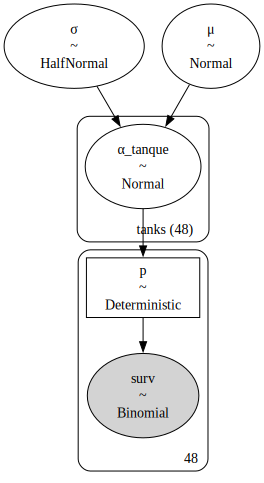

In [10]:
pm.model_to_graphviz(modelo_renacuajos)

En la siguiente figura se muestran las proporciones empíricas de sobrevivientes en cada tanque de renacuajos (puntos azules) y las proporciones estimadas por el modelo (puntos turquesa). La línea discontinua indica la proporción promedio de sobrevivientes teniendo en cuenta todos los tanques. Las lineas verticales dividen los tanques de acuerdo a las diferentes densidades iniciales de renacuajos: tanques pequeños (10), tanques medianos (25) y tanques grandes (35). En cada tanque, la media a posteriori del modelo multinivel está más cerca de la línea punteada que la proporción empírica. Esto refleja la información compartida entre tanques y el efecto de contracción.

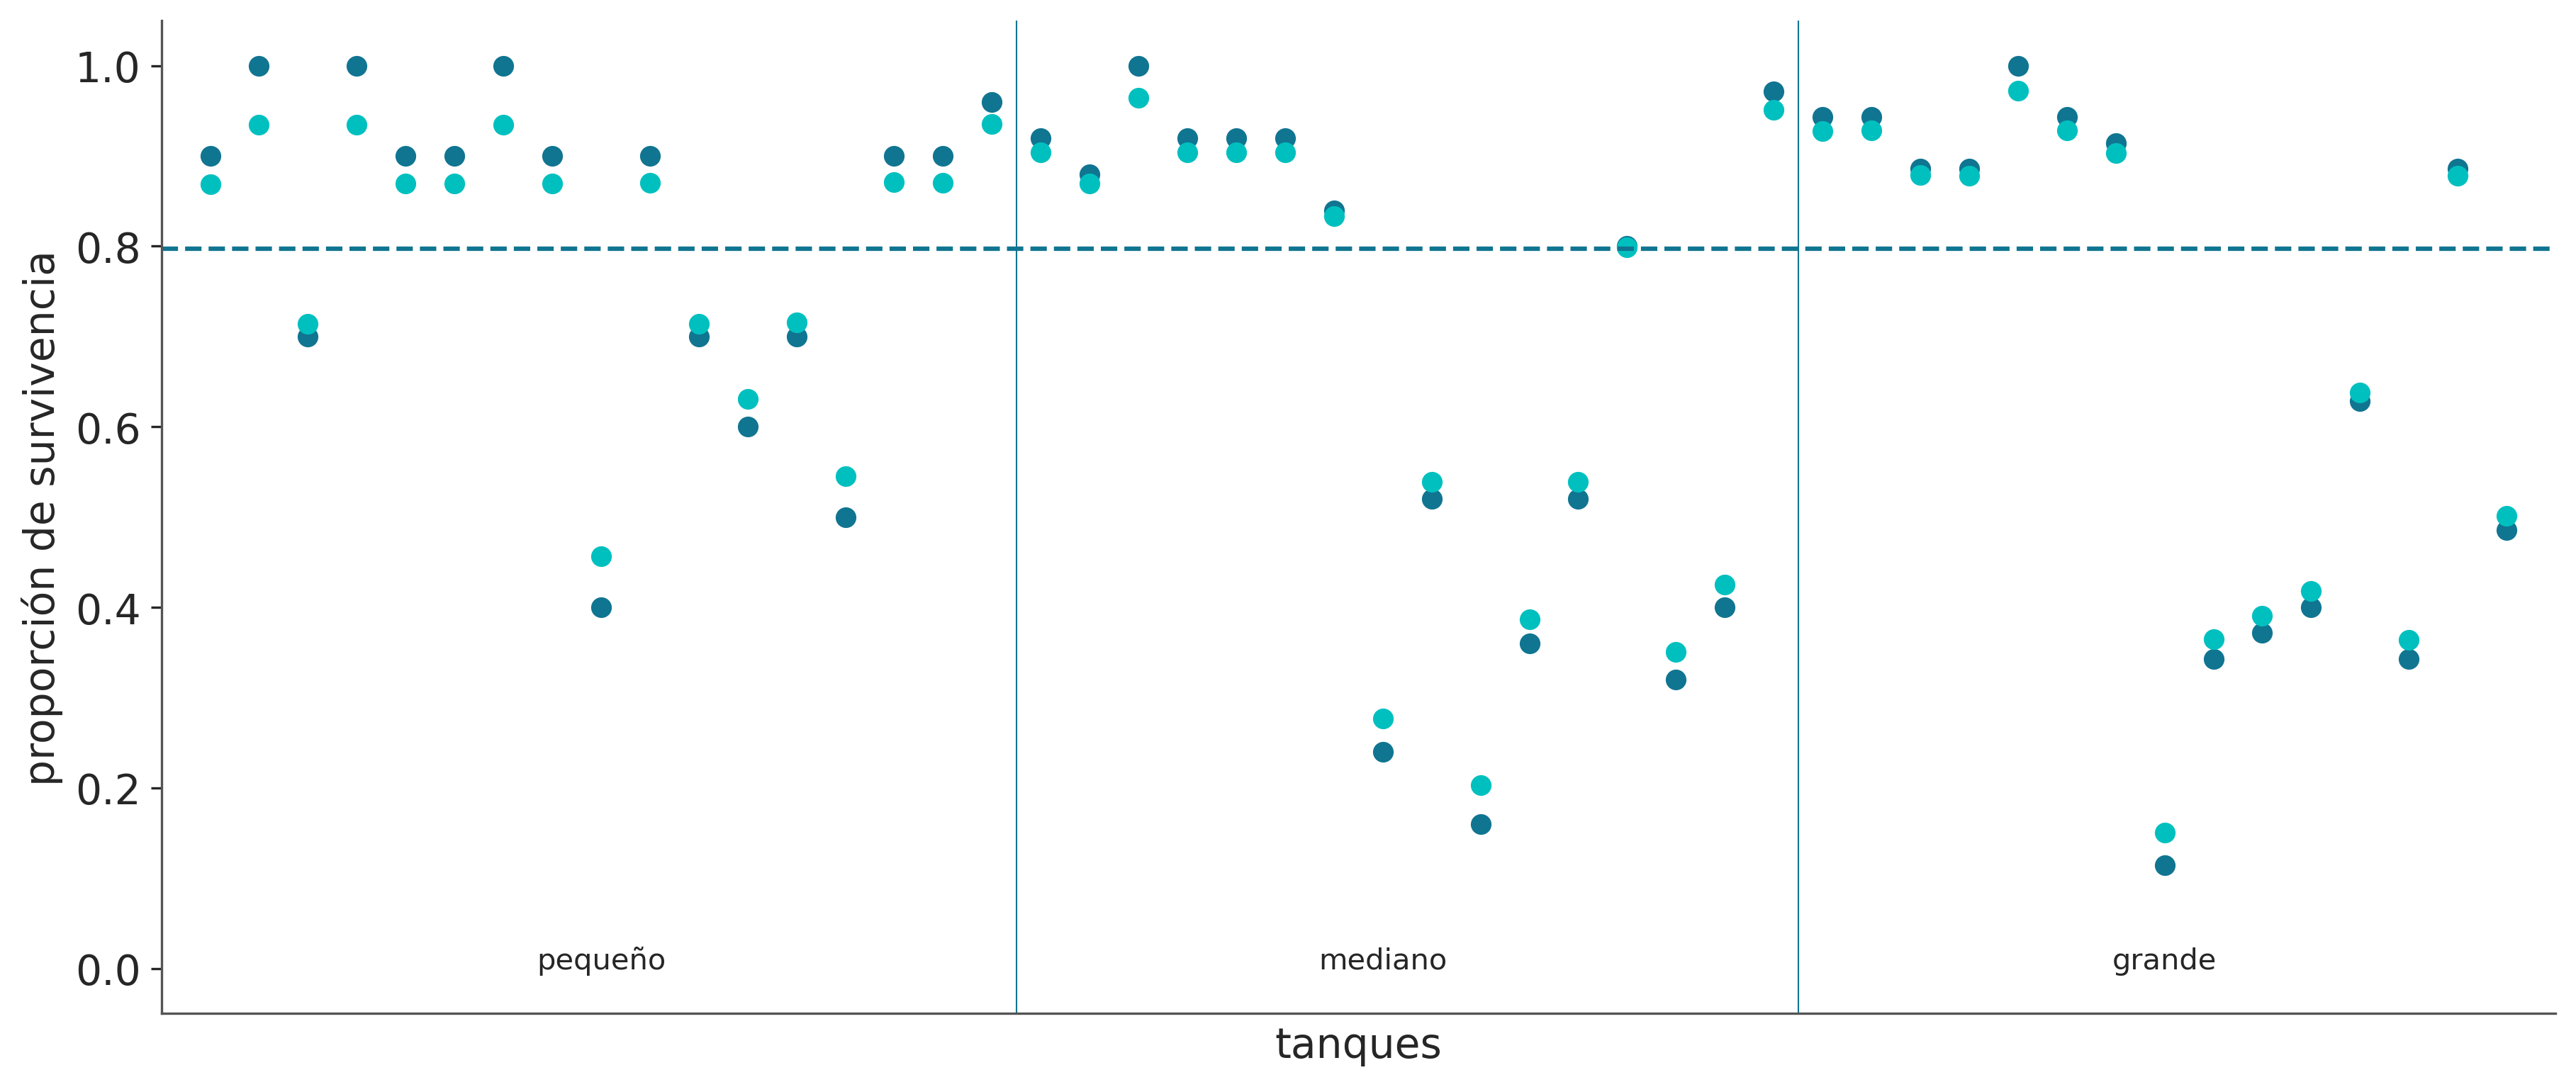

In [11]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

post_r = az.extract(idata_renacuajos)

ax.scatter(np.arange(0, 48), d.propsurv, color='C0')
ax.scatter(np.arange(0, 48), post_r['p'].mean("sample"), color='C1')
ax.hlines(logistic(post_r['μ'].median("sample")), -1, 49, linestyles='--')

idx = d.density[d.density.diff() > 0].index
ax.vlines(idx + 0.5, -.05, 1.05, lw=.5)
for i, t in zip(np.linspace(0, 48, 7)[1::2], ('pequeño', 'mediano', 'grande')):
    ax.text(i, 0, t, horizontalalignment='center')
ax.set_xlabel('tanques')
ax.set_ylabel('proporción de survivencia')
ax.set_xlim(-1, 48)
ax.set_xticks([])
ax.set_ylim(-.05, 1.05)
ax.grid(False)

## Jerarquías futboleras


Varias estructuras de datos se prestan a descripciones jerárquicas que pueden abarcar múltiples niveles. Por ejemplo, jugadores profesionales de fútbol. Como en muchos otros deportes, los jugadores tienen diferentes posiciones dentro de la cancha. Es posible que nos interese estimar algunas métricas de habilidad para cada jugador, para las posiciones y para el grupo general de jugadores de fútbol profesional. Este tipo de estructura jerárquica también se puede encontrar en muchos otros dominios, como:

* Investigación médica: Supongamos que estamos interesados en estimar la eficacia de diferentes fármacos para el tratamiento de una determinada enfermedad. Podemos categorizar a los pacientes según su información demográfica, la gravedad de la enfermedad y otros factores relevantes y construir un modelo jerárquico para estimar la probabilidad de curación o el éxito del tratamiento para cada subgrupo. Luego podemos usar los parámetros de la distribución de subgrupos para estimar la probabilidad general de curación o éxito del tratamiento para toda la población de pacientes.

* Ciencias ambientales: Supongamos que estamos interesados en estimar el impacto de un determinado contaminante en un ecosistema particular. Podemos categorizar diferentes hábitats dentro del ecosistema (p. ej., ríos, lagos, bosques, humedales) y construir un modelo jerárquico para estimar la distribución de los niveles de contaminantes dentro de cada hábitat. Luego podemos usar los parámetros de la distribución del hábitat para estimar la distribución general de los niveles de contaminantes dentro del ecosistema.

* Investigación de mercado: supongamos que estamos interesados en comprender el comportamiento de compra de los consumidores de un producto en particular en diferentes regiones. Podemos categorizar a los consumidores según su información demográfica (por ejemplo, edad, sexo, ingresos, educación) y construir un modelo jerárquico para estimar la distribución del comportamiento de compra para cada subgrupo. Luego podemos usar los parámetros de la distribución del subgrupo para estimar la distribución del comportamiento de compra para el grupo general de consumidores.

Volviendo a nuestros jugadores de fútbol, hemos recopilado datos de la *Premier League*, *Ligue 1*, *Bundesliga*, *Serie A* y *La Liga*, en el transcurso de cuatro años (2017 a 2020). Supongamos que estamos interesados en la métrica de goles por tiro. Esto es lo que los estadísticos suelen llamar *tasa de éxito*, y podemos estimarlo con un modelo Binomial donde el parámetro $n$ es el número de tiros y las observaciones $y$ es el número de goles. Esto nos deja con un valor desconocido para $p$, en ejemplos anteriores hemos estado llamando a este parámetro $\theta$ y hemos usado una distribución Beta para modelarlo. Haremos lo mismo ahora, pero jerárquicamente. $\theta$ representa la "tasa de éxito" de cada jugador y, por lo tanto, es un vector de tamaño `n_jugadores`. Usamos una distribución Beta para modelar $\theta$. Los hiperparámetros de la distribución Beta serán los vectores $\mu_p$ y $\nu_p$, que son vectores de tamaño 4, que representan las cuatro posiciones en nuestro conjunto de datos (defensor `DF`, centrocampista `MF`, delantero `FW` y arquero `GK`). Tendremos que indexar correctamente los vectores $\mu_p$ y $\nu_p$ para que coincidan con el número total de jugadores. Finalmente, tendremos dos parámetros globales, $\mu$ y $\nu$, que representan a los futbolistas profesionales.


El modelo PyMC se define en el siguiente bloque de código. El `pm.Beta('mu', 1.7, 5.8)` fue elegido con la ayuda de PreliZ como prior con el 90% de la masa entre 0 y 0.5. Este es un ejemplo de un prior poco informativo, ya que no hay duda de que una tasa de éxito de 0,5 es un valor alto. Las estadísticas deportivas están bien estudiadas y hay mucha información previa que podría usarse para definir priors más fuertes. Para este ejemplo, nos conformaremos con este prior. Una justificación similar se puede hacer para el prior `pm.Gamma('nu', mu=125, sigma=50)`, que definimos como la distribución Gamma de máxima entropía con el 90% de la masa entre 50 y 200.

In [12]:
futbol = pd.read_csv("datos/futbol.csv", dtype={'posición':'category'})
pos_idx = futbol.posición.cat.codes.values
pos_codes = futbol.posición.cat.categories
n_pos = pos_codes.size
n_jugadores = futbol.index.size

In [13]:
coords = {"pos": pos_codes}
with pm.Model(coords=coords) as modelo_futbol:
    # Hiper-parámetros
    μ = pm.Beta('μ', 1.7, 5.8) 
    ν = pm.Gamma('ν', mu=125, sigma=50)

    
    # Parámetros por posición
    μ_p = pm.Beta('μ_p',
                       mu=μ,
                       nu=ν,
                       dims = "pos")
    
    ν_p = pm.Gamma('ν_p', mu=125, sigma=50, dims="pos")
 
    # Parámetros por jugador
    θ = pm.Beta('θ', 
                    mu=μ_p[pos_idx],
                    nu=ν_p[pos_idx])
    
    _ = pm.Binomial('gs', n=futbol.tiros.values, p=θ, observed=futbol.goles.values)

    idata_futbol = pm.sample(4000, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, μ_p, ν_p, θ]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 465 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


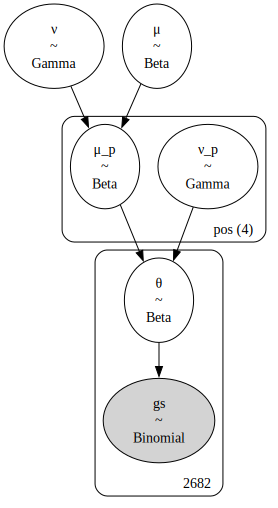

In [14]:
pm.model_to_graphviz(modelo_futbol)

En el panel superior de la siguiente figura tenemos la distribución a posteriori del parámetro global $\mu$. La distribución a posteriori es cercana a 0.1. Lo que significa que, en general, para un jugador de fútbol profesional, la probabilidad de hacer un gol es en promedio del 10%. Este es un valor razonable, ya que hacer goles no es una tarea fácil y no estamos discriminando posiciones, es decir, estamos considerando jugadores cuyo papel principal no es el de hacer goles. En el panel central, tenemos el valor estimado de $mu_p$ para la posición de defensa, como es de esperar, es más alto que el parámetro global $\mu$. En el panel inferior, tenemos el valor estimado de $\theta$ para Lionel Messi, con un valor de 0.17, que es más alto que el parámetro global $\mu$ y el valor de la posición delantera $\mu_p$. Esto también es de esperarse, ya que Lionel Messi es el mejor jugador de fútbol del mundo, y su rol principal es hacer goles.

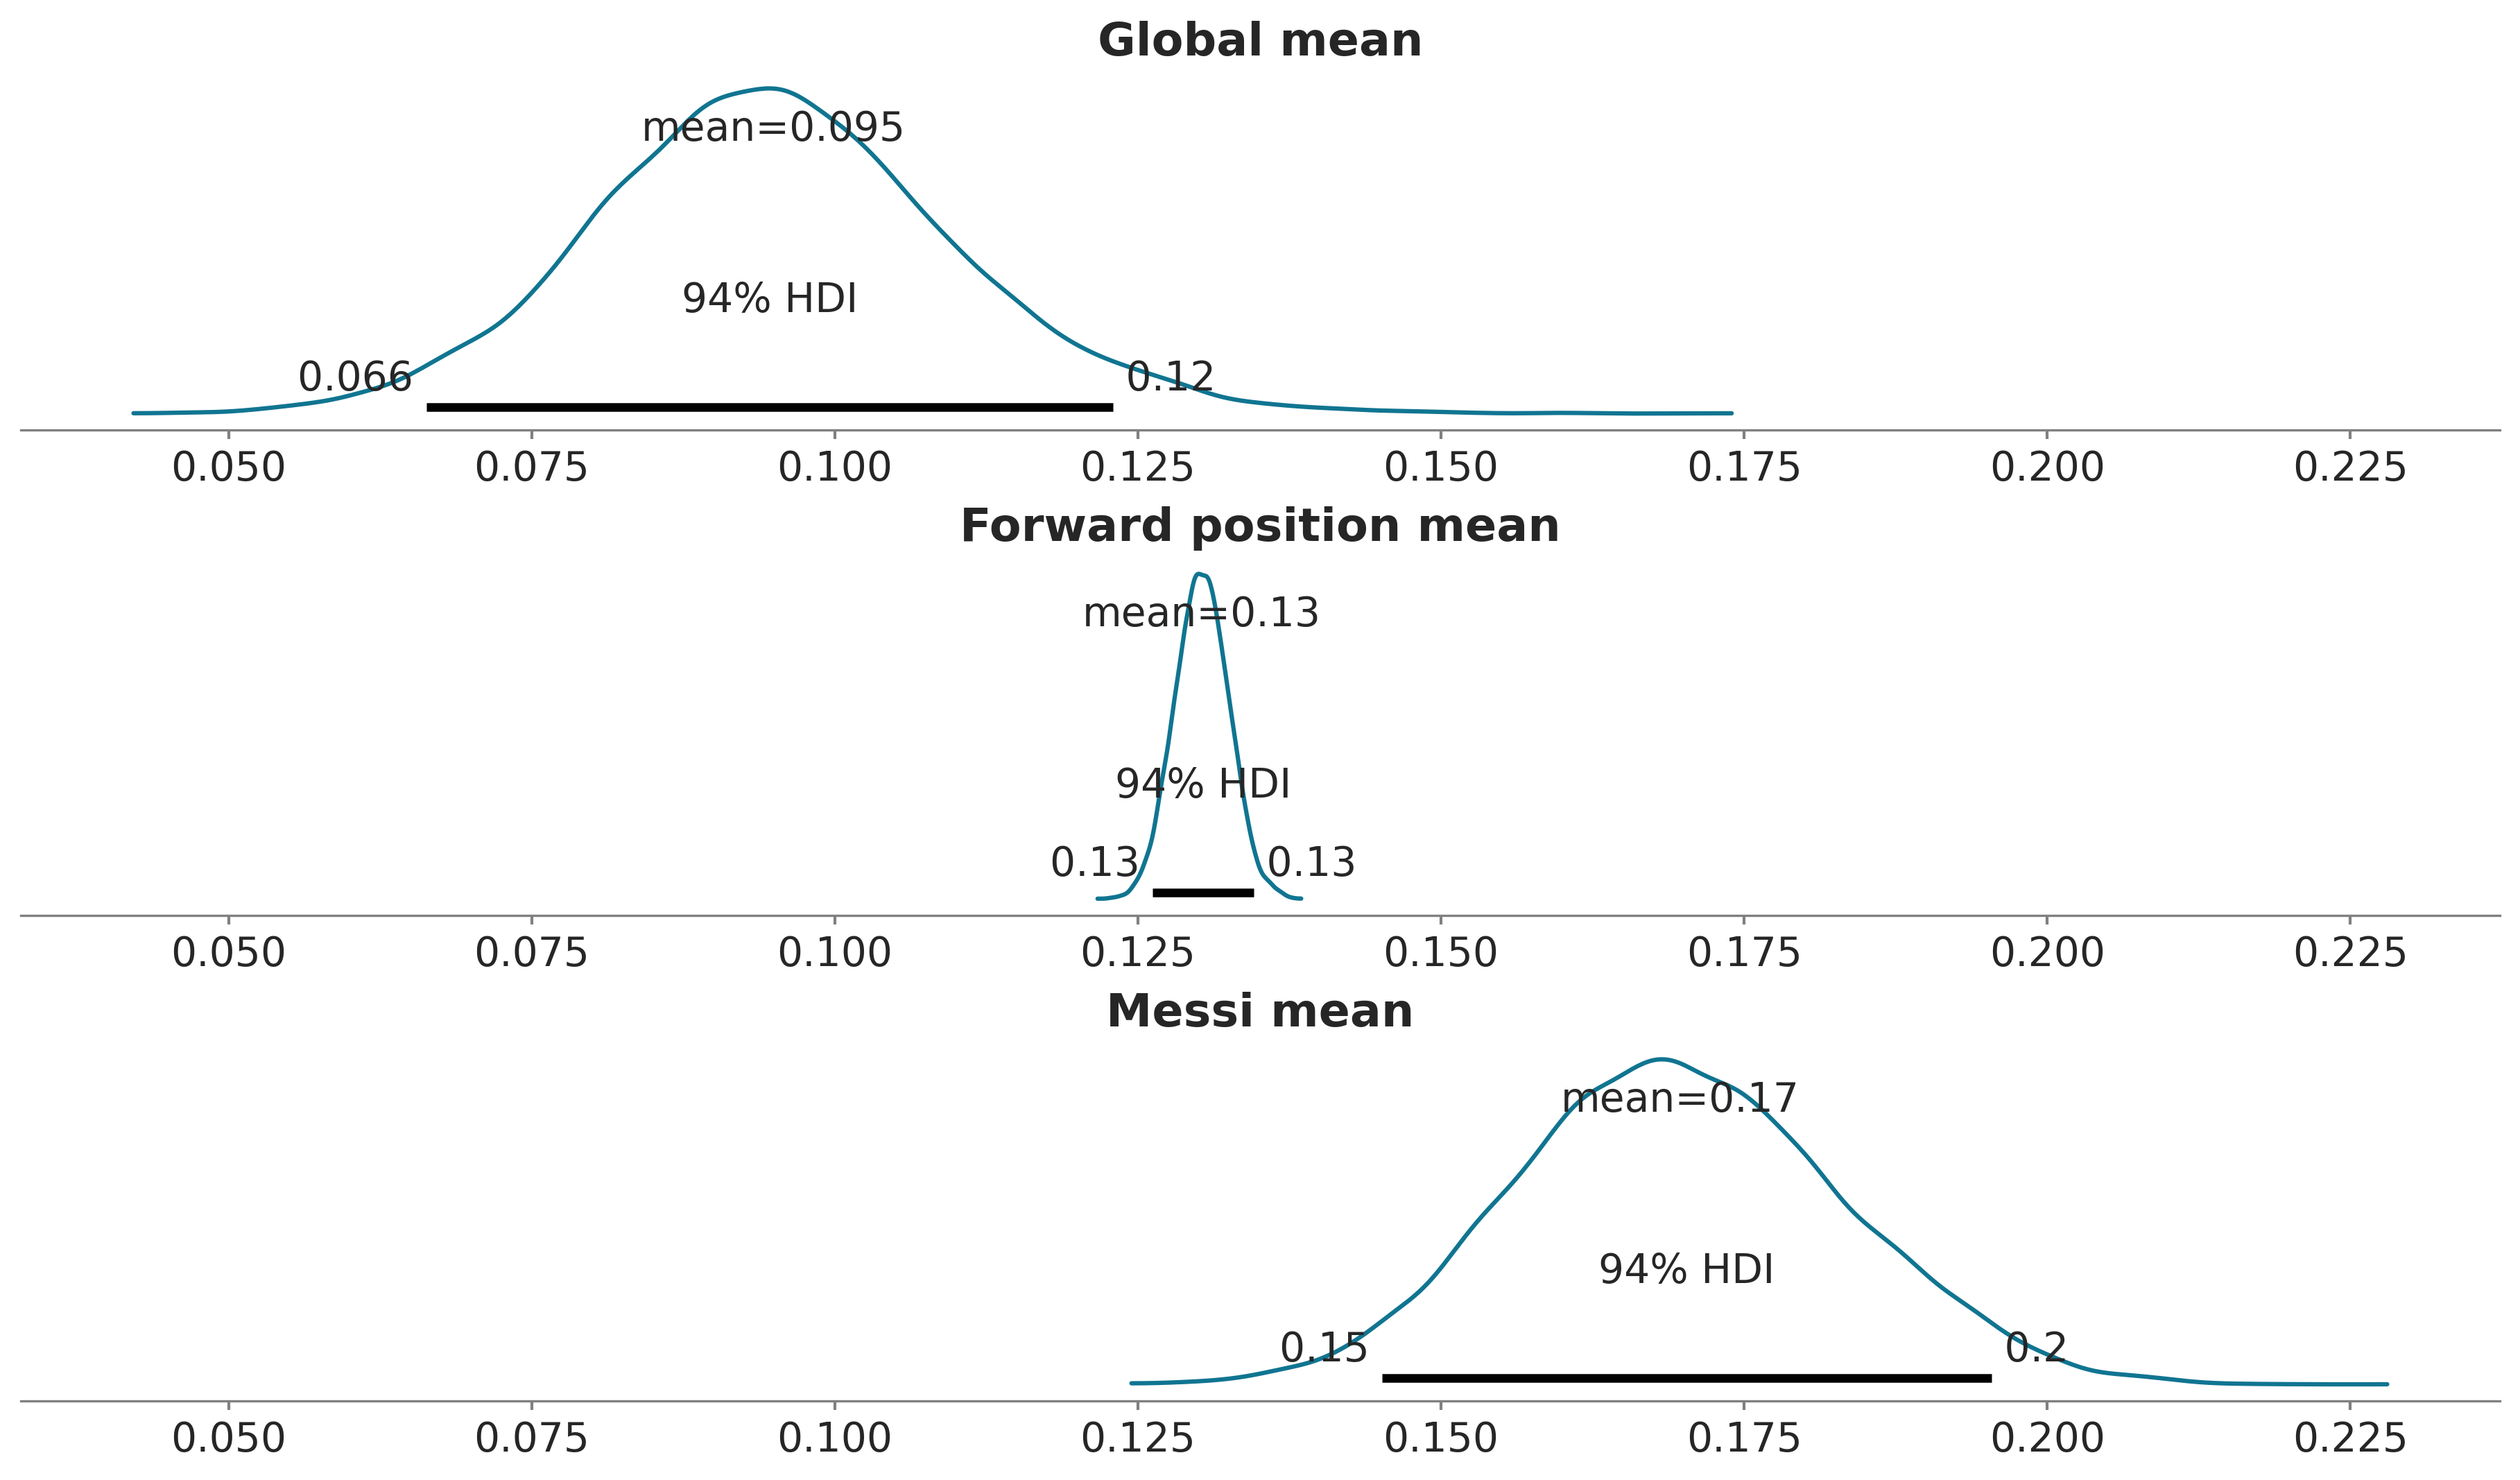

In [15]:
_, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
az.plot_posterior(idata_futbol, var_names='μ', ax=ax[0])
ax[0].set_title(r"Global mean")
az.plot_posterior(idata_futbol.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")
az.plot_posterior(idata_futbol.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].set_title(r"Messi mean");

La siguiente figura muestra un `forest plot` para la distribución a posteriori del parámetro $\mu_p$. La distribución a posteriori para delanteros se centra en torno a 0.13, como ya vimos, y es la más alta de las cuatro. Esto tiene sentido ya que el papel de los jugadores en una posición delantera es hacer goles y asistencias. El valor más bajo de $\mu_p$ es para la posición de arquero. Esto esperable, ya que la función principal es evitar que el equipo contrario haga goles. El aspecto interesante es que la incertidumbre es muy alta, esto se debe a que tenemos muy pocos arqueros haciendo goles en nuestro conjunto de datos, 3 para ser precisos. Las distribuciones a posteriori para las posiciones de defensa y mediocampo están en *el medio*, siendo ligeramente más altas para los mediocampistas. Podemos explicar esto porque el papel principal de un mediocampista es defender y atacar, y por lo tanto la probabilidad de marcar un gol es mayor que la de un defensor pero menor que la de un delantero.

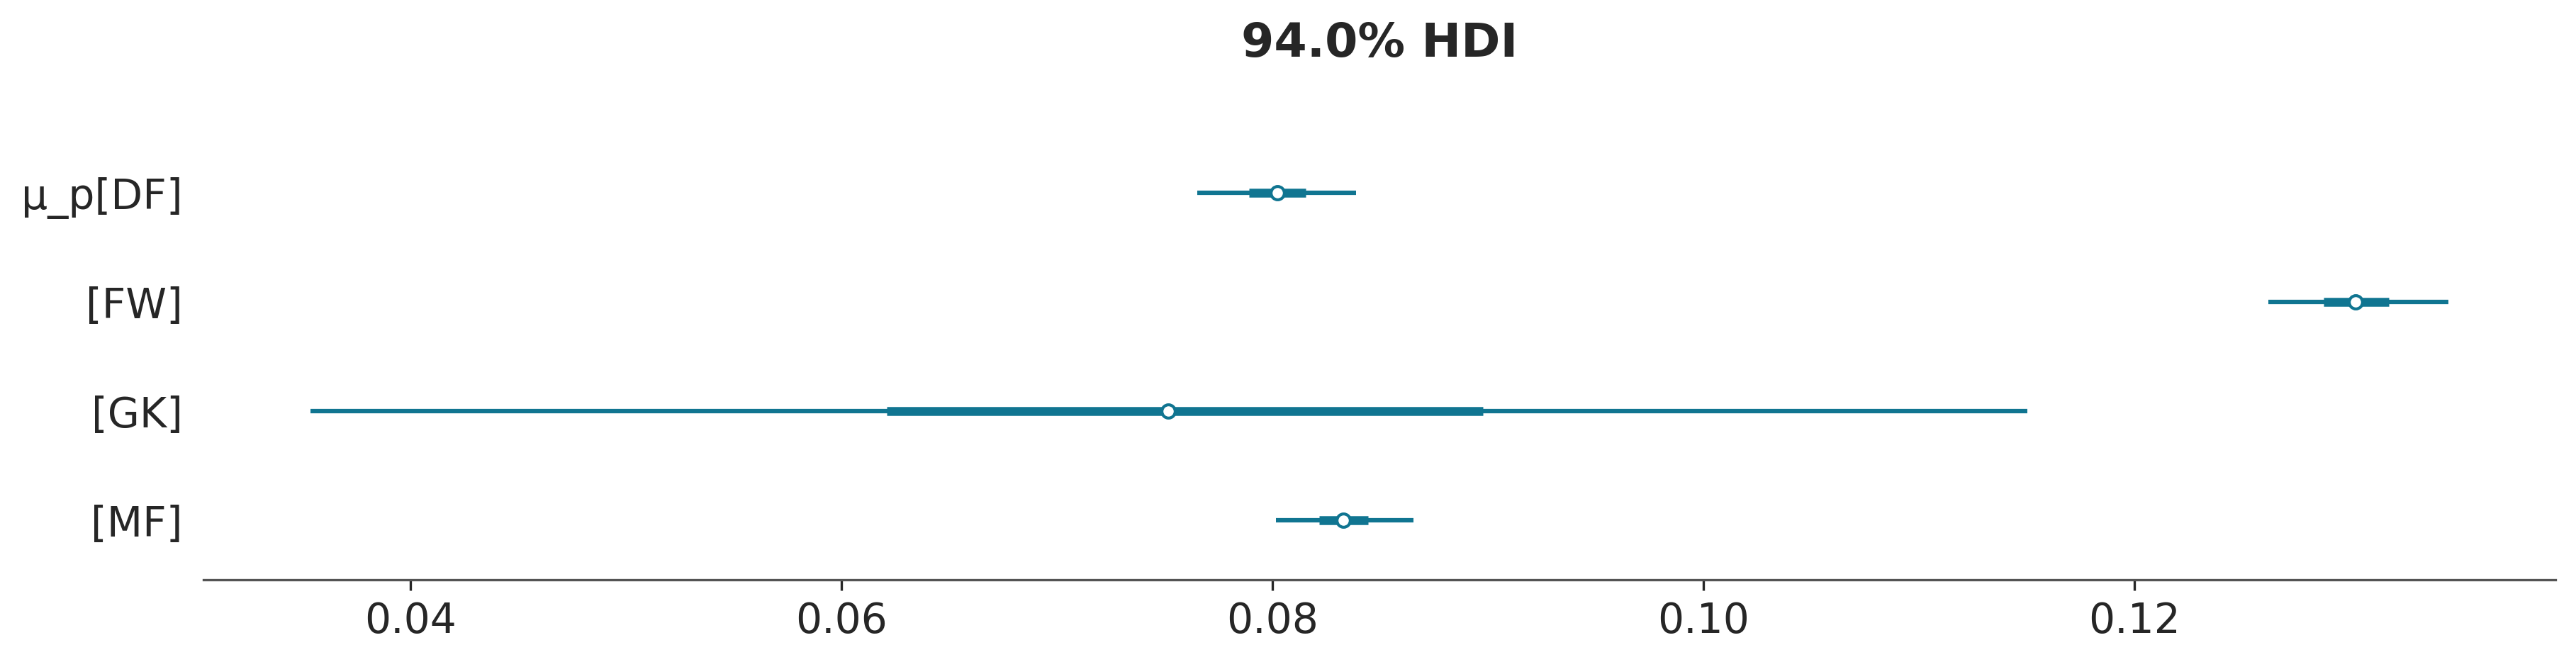

In [16]:
az.plot_forest(idata_futbol, var_names=['μ_p'], combined=True, figsize=(12, 3));

## Resumen

En este capítulo hemos descrito uno de los conceptos más importantes de este curso: los modelos jerárquicos. Podemos construir modelos jerárquicos cada vez que podamos identificar subgrupos en nuestros datos. En tales casos, en lugar de tratar los subgrupos como entidades separadas o ignorar los subgrupos y tratarlos como un solo gran-grupo, podemos construir un modelo para agrupar-parcialmente la información entre los grupos. 

El principal efecto de este agrupamiento-parcial es que las estimaciones de cada subgrupo estarán sesgadas por las estimaciones del resto de los subgrupos. Este efecto se conoce como contracción y, en general, es un _truco_ muy útil que ayuda a mejorar las inferencias haciéndolas más conservadoras (ya que cada subgrupo informa a los demás acercando el resto de las estimaciones hacia él) y más informativas, obtenemos estimaciones a nivel de subgrupo y el nivel del grupo.

## Para seguir leyendo

* Capítulo 5 de Bayesian Data Analysis de Gelman et al. [BDA3](https://www.stat.columbia.edu/~gelman/book/BDA3.pdf)
* Bernardo, J. M. (1996). The concept of exchangeability and its applications. Far East J. Mathematical Sciences 4, 111-121. [Exchangeability](http://www.uv.es/~bernardo/Exchangeability.pdf)

## Ejercicios

1. (Borrador). Escribir el teorema de bayes para un modelo jerárquico. La idea es que escriban, likelihood, prior e hyperprior.

1. (Borrador). Escribir enunciado tuberías jerarquicas (ver ejemplo en repo privado).

1. (Borrador, este ejericio asume que ya vimos el ejemplo de las propinas, si no es así podríamos introducir el ejemplo y pedir que ajusten el modelo jerarquico y no jerarquico). Creá una versión jerárquica para el ejemplo de las propinas agrupando parcialmente los días de la semana.

1. (Borrador), Cuando se utilizan distribuciones a priori débilmente informativos, las predicciones medias a posteriori de un modelo normal-normal jerárquico son (aproximadamente) promedios pesado de la siguiente forma:


$$
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j.
$$

donde $\overline{y}_{\text{global}}$ es la media de todas las observaciones, $\overline{y}_j$ es la media de las observaciones en el grupo $j$, $n_j$ es el número de observaciones en el grupo $j$, $\sigma^2_y$ es la varianza de las observaciones y $\sigma^2_\mu$ es la varianza de las medias de los grupos. Indique en que condiciones las prediccions a nivel individual se contraeran más hacia la predicción global.

1. Aplicá al menos uno de los modelos visto en este capítulo a datos propios o de tu interés.